In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.cluster import KMeans
import dexplot as dxp    ## For perc distribution of categorical variable

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [171]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/13On3HXpkBD8mrzo4f4G5Hx24qqJkmoon4IWAbplYIAg/export?format=csv&gid=0')

In [172]:
# Snapshot of the data

data.head()

,CustomerID,Gender,Age,AnnualIncome,SpendingScore
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [173]:
# Size of the data
data.shape

(200, 5)

In [174]:
# Info of the data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     200 non-null    int64 
 1   Gender         200 non-null    object
 2   Age            200 non-null    int64 
 3   AnnualIncome   200 non-null    int64 
 4   SpendingScore  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [175]:
data.describe(include = 'all')

,CustomerID,Gender,Age,AnnualIncome,SpendingScore
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


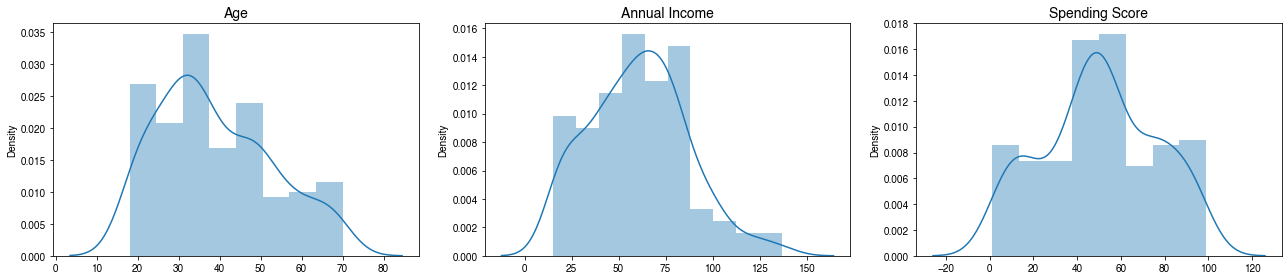

In [176]:
# Univariate Analysis
# Creating the distplots for all variables (Univariate Analysis)

plt.figure(figsize = (18,4))

plt.subplot(131)
sns.distplot(data['Age'])
plt.title('Age', fontsize = 14)
plt.xlabel('')
plt.tight_layout(h_pad = 3, w_pad = 2)

plt.subplot(132)
sns.distplot(data['AnnualIncome'])
plt.title('Annual Income', fontsize = 14)
plt.xlabel('')
plt.tight_layout(h_pad = 3, w_pad = 2)

plt.subplot(133)
sns.distplot(data['SpendingScore'])
plt.title('Spending Score', fontsize = 14)
plt.xlabel('')
plt.tight_layout(h_pad = 3, w_pad = 2)

plt.show()

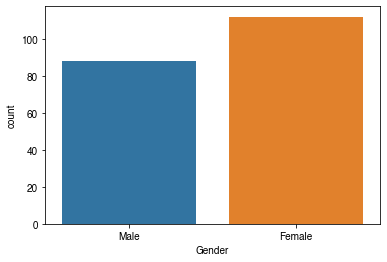

In [177]:
sns.countplot(data['Gender'])
plt.show()

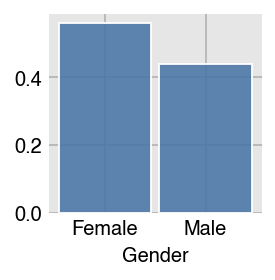

In [178]:
dxp.count('Gender', data=data, normalize=True)

In [179]:
data.groupby('Gender').agg({'Gender': 'count'})

,Gender
Gender,
Female,112
Male,88


### Bivariate Analysis

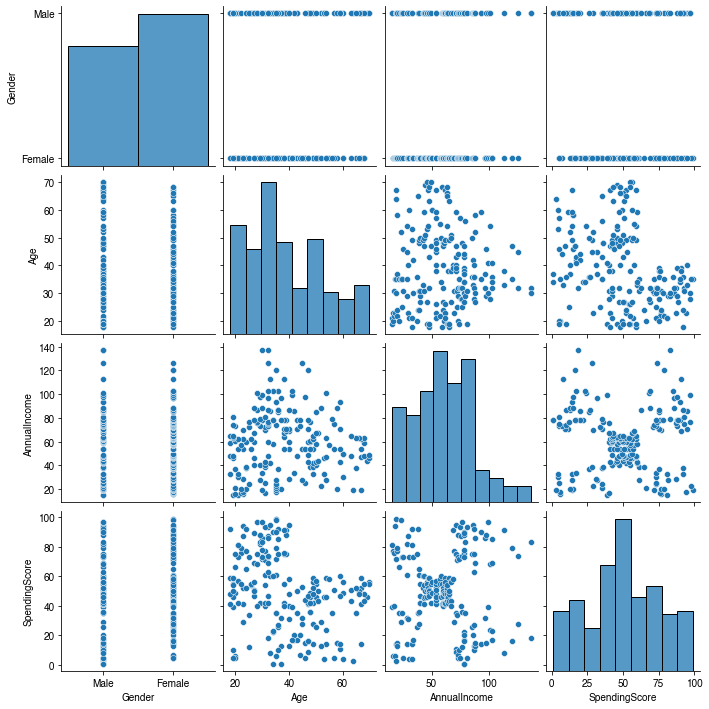

In [180]:
# Pairplots of all variables (Bivariate Analysis)

sns.pairplot(data, vars = ['Gender', 'Age', 'AnnualIncome', 'SpendingScore'])
plt.show()

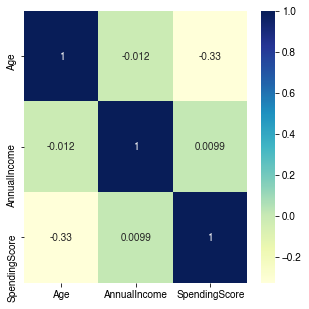

In [181]:
# Correlation plot

num = data[['Age', 'AnnualIncome', 'SpendingScore']]

plt.figure(figsize = (5,5))
sns.heatmap(num.corr(), cmap = "YlGnBu", annot = True)
plt.show()

In [182]:
corrMatrix = num.corr()
print (corrMatrix)

                    Age  AnnualIncome  SpendingScore
Age            1.000000     -0.012398      -0.327227
AnnualIncome  -0.012398      1.000000       0.009903
SpendingScore -0.327227      0.009903       1.000000


### Data Pre-processing

In [204]:
# Creating the DataFrame for modelling

model_df = data[['CustomerID','Gender','Age', 'AnnualIncome', 'SpendingScore']]

In [205]:
model_df.drop('CustomerID',axis = 1, inplace = True)

In [206]:
model_df

,Gender,Age,AnnualIncome,SpendingScore
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


In [208]:
numeric = model_df.select_dtypes([np.int64,np.float64]).columns
cat = model_df.select_dtypes(exclude = np.int64).columns

Index(['Age', 'AnnualIncome', 'SpendingScore'], dtype='object')

In [209]:
#Standardization for Numeric variables
scalar = sklearn.preprocessing.StandardScaler()
model_df[numeric] = scalar.fit_transform(model_df[numeric])

In [210]:
## Dummification for Categorical variables
dummy_var = pd.get_dummies(model_df[cat], drop_first = True)
model_df = pd.concat([model_df, dummy_var], axis = 1)
model_df.drop(cat, axis = 1, inplace = True)

In [212]:
cat

Index(['Gender'], dtype='object')

In [213]:
model_df

,Age,AnnualIncome,SpendingScore,Gender_Male
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0
...,...,...,...,...
195,-0.276302,2.268791,1.118061,0
196,0.441365,2.497807,-0.861839,0
197,-0.491602,2.497807,0.923953,1
198,-0.491602,2.917671,-1.250054,1


## K-means Clustering

#### Creating Elbow plot for clustering

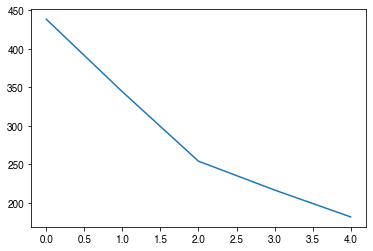

In [214]:
ssd = []
range_n_clusters = [2,3,4,5,6]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmeans.fit(model_df)
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)
plt.show()

In [215]:
ssd

[438.5224115567773,
 344.40542886953494,
 254.28290726083466,
 216.85928292083833,
 181.9514362434146]

In [216]:
# Running the KMeans algorithm for 2 clusters

kmeans = KMeans(n_clusters = 2, max_iter = 50)
kmeans.fit(model_df)

kmeans.labels_

array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=int32)

In [217]:
# Adding the labels to the original DataFrame
data['cluster_id'] = kmeans.labels_
data

,CustomerID,Gender,Age,AnnualIncome,SpendingScore,cluster_id
0,1,Male,19,15,39,1
1,2,Male,21,15,81,1
2,3,Female,20,16,6,0
3,4,Female,23,16,77,1
4,5,Female,31,17,40,1
...,...,...,...,...,...,...
195,196,Female,35,120,79,1
196,197,Female,45,126,28,0
197,198,Male,32,126,74,1
198,199,Male,32,137,18,0


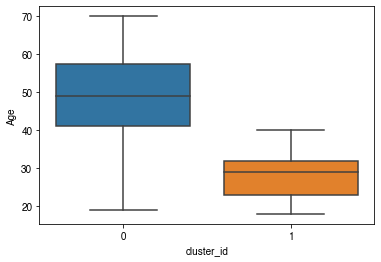

In [218]:
# Analyzing the clusters based on GDP per Capita

sns.boxplot(x = 'cluster_id', y = 'Age', data = data)
plt.show()

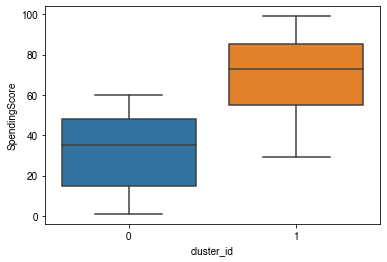

In [219]:
# Analyzing the clusters based on GDP per Capita

sns.boxplot(x = 'cluster_id', y = 'SpendingScore', data = data)
plt.show()

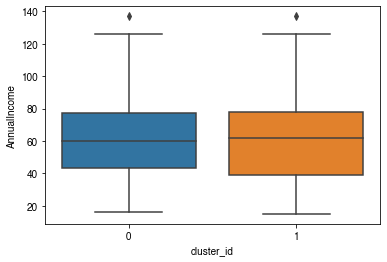

In [226]:
# Analyzing the clusters based on GDP per Capita

sns.boxplot(x = 'cluster_id', y = 'AnnualIncome', data = data)
plt.show()

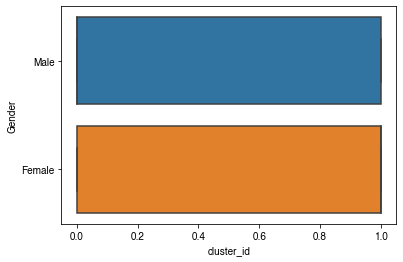

In [220]:
sns.boxplot(x = 'cluster_id', y = 'Gender', data = data)
plt.show()

In [227]:
# Export final DataFrames

data.to_csv('all_clusters.csv', index = False, header = True)